# Image Classification with Gemini (Company Policy Moderation)

This notebook demonstrates how to use Gemini via Pydantic AI for image classification to enforce company policies. We'll use a fake company policy scenario to show how you might moderate content in a business context.

## Environment Setup

Make sure the `.env` file in the *parent* directory of this notebook is appropriately filled up with your API key for Gemini:

```
GEMINI_API_KEY=your_api_key_here
...
```

In [ ]:
import os
from dotenv import load_dotenv
from typing import List
from PIL import Image

# Load environment variables
assert load_dotenv("../.env"), "Could not load credentials! Make sure you have a .env file in the parent directory"

# Verify API key is loaded
if not os.getenv('GEMINI_API_KEY'):
    raise ValueError("GEMINI_API_KEY not found in environment variables")

# Only needed on the Udacity workspace. Comment this out if running on another system.
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

In [3]:
# Need this for pydantic AI
import nest_asyncio

nest_asyncio.apply()

## Define Company Policy Rules

Let's imagine we are a company and we need to enforce a policy for the sharing of workplace imagery on social media. Let's define the types of policy violation we want to detect:

In [4]:
from pydantic import BaseModel, Field
from enum import Enum


# Here we define the possible violation in a Enum
class PolicyViolationType(str, Enum):
    NONE = "none"
    UNPROFESSIONAL_ATTIRE = "unprofessional_attire"
    FOOD_IN_MEETING_ROOM = "food_in_meeting_room"
    PERSONAL_ITEMS_ON_DESK = "personal_items_on_desk"
    UNORGANIZED_WORKSPACE = "unorganized_workspace"
    CONFIDENTIAL_INFO_VISIBLE = "confidential_info_visible"


# We define the schema (aka data model) for our output
class ModerationResult(BaseModel):
    """Result of company policy moderation check"""
    
    # TODO: add a is_compliant field of type boolean and a suitable description. Use the Field class to
    # add the description of the parameter
    # [field_name]: [field_type] = Field(description="...")
    is_compliant: bool = Field(
        description="Whether the image complies with company policy"
    )
    # TODO: add the violations field with a type corresponding to a *list* of PolicyViolationType.
    # Again, use the Field class to add a suitable description
    violations: List[PolicyViolationType] = Field(
        description="List of policy violations if any"
    )
    # NOTE: a lot of people use a confidence number to try to gather the
    # confidence of the detection. Unfortunately, it has been proven that this
    # often does not work reliably, LLMs just don't work that way!
    # So we won't do it here. There are other techniques to approach this,
    # like generating multiple answers and voting, but they go beyond the scope
    # of this notebook
    # confidence: float = Field(
    #     ge=0.0, le=1.0,
    #     description="Confidence score for the assessment (0-1)"
    # )
    explanation: str = Field(
        description="Brief explanation of the decision"
    )
    suggested_action: str = Field(
        description="Recommended action if policy is violated"
    )

## Create the Pydantic AI Agent

Now we'll create a Pydantic AI agent that uses Gemini to analyze images and determine if they comply with our company policy.

In [15]:
from pydantic_ai import Agent
from pydantic_ai.models.google import GoogleModelSettings


# Company policy prompt
COMPANY_POLICY_PROMPT = """
You are a workplace policy compliance agent for TechCorp Inc. Analyze images to ensure they comply with 
our guidelines for social media sharing:

POLICY VIOLATIONS TO CHECK:
1. UNPROFESSIONAL_ATTIRE: Overly casual clothing in client-facing areas
2. FOOD_IN_MEETING_ROOM: Food or drinks in designated meeting rooms
3. PERSONAL_ITEMS_ON_DESK: Excessive personal items cluttering workspace
4. UNORGANIZED_WORKSPACE: Messy or unprofessional workspace setup
5. CONFIDENTIAL_INFO_VISIBLE: Documents, screens, or whiteboards with sensitive info

IMPORTANT:
- Be reasonable and consider context
- A coffee mug or small personal photo is generally acceptable
- Focus on professional appearance and information security
- If uncertain, lean toward compliance unless clearly problematic

Provide a clear explanation for your decision.
"""

model_settings = GoogleModelSettings(
    temperature=0.2,  # Range: 0.0 to 2.0, default is 1.0
    seed=42,
)

# TODO: create the agent with Gemini model. Use gemini-2.5-flash-lite
# and remember to set the output_type to our output schema. Also remember
# to set system_prompt to our prompt!
moderation_agent = Agent(
    "gemini-2.5-flash-lite",  # Using latest Gemini model
    output_type=ModerationResult,
    system_prompt=COMPANY_POLICY_PROMPT,
    model_settings=model_settings,
    retries=3,  # Retry up to 3 times on failure
)

## Helper Functions

Let's create some utility functions to handle image processing and analysis.

In [16]:
from io import BytesIO

from pydantic_ai import BinaryContent


def moderate_image(
    img: Image.Image, agent: Agent
) -> ModerationResult:

    # Limit size to reduce token usage
    img.thumbnail((600, 600))

    # Format image
    image_bytes = BytesIO()
    img.save(image_bytes, format="JPEG")

    # Run analysis
    result = agent.run_sync(
        [BinaryContent(data=image_bytes.getvalue(), media_type="image/jpeg")],
    )

    return result.output

## Demo: Simulated Image Analysis

Since we can't include actual images in this demo, we'll use a trick: we will generate image with Gemini and have another Gemini moderate them. This way we can generate as much data as we want! (although it might get expensive, and in practice a smaller, more targeted image-generation model might be more viable for this)

In [25]:
# We define a pydantic data model for a test case scenario
class TestScenario(BaseModel):
    name: str
    description: str
    expected_moderation_result: PolicyViolationType

# We define a few scenarios
test_scenarios = [
    TestScenario(
        name="Clean Professional Workspace",
        description="a view of a person on a web call in a professional context",
        expected_moderation_result=PolicyViolationType.NONE,
    ),
    TestScenario(
        name="Messy Desk with Food",
        description="a desk covered with pizza boxes, multiple drinks, papers scattered everywhere, and personal items like toys and photos covering the workspace.",
        expected_moderation_result=PolicyViolationType.FOOD_IN_MEETING_ROOM,
    ),
    # TODO: add a few test scenarios yourself!
    TestScenario(
        name="Screen with Confidential Data",
        description="A computer screen clearly displaying employee salary information visible to anyone walking by.",
        expected_moderation_result=PolicyViolationType.CONFIDENTIAL_INFO_VISIBLE
    ),
]

print(f"Created {len(test_scenarios)} test scenarios")

Created 3 test scenarios


## Run the Analysis

Let's run our moderation agent on the test scenarios.

> *NOTE*: in a real use case, even if you used simulated data you would have to repeat each test scenario many times and determine for example the proportion of times the appropriate violation is contained in the list of violations returned by the model. Here we don't do that because it would take a lot of time

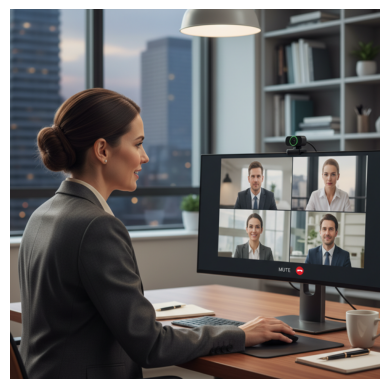

The image shows a professional in a business suit participating in a
video conference. The workspace is tidy, and no confidential
information is visible.
Violations: ['none']


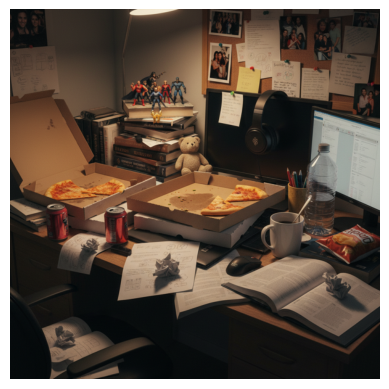

The image shows pizza boxes, cans, and a bag of chips on the desk,
which are food items. The desk is also cluttered with papers, books,
and personal items, indicating an unorganized workspace. It is unclear
if this is a meeting room, but food is generally not allowed in such
areas.
Violations: ['food_in_meeting_room', 'unorganized_workspace']


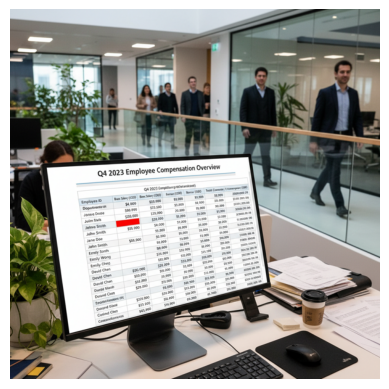

The image displays a computer screen showing an "Employee Compensation
Overview" report, which contains sensitive and confidential
information. Sharing this image on social media would violate the
company policy against visible confidential information.
Violations: ['confidential_info_visible']


In [27]:
from google import genai
from google.genai import types
import matplotlib.pyplot as plt
import textwrap

from PIL import Image
from io import BytesIO
import os


def generate_and_moderate_image(test_scenario: TestScenario, moderation_agent: Agent):
    # Initialize Gemini client (make sure you have GEMINI_API_KEY env var set)
    client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

    prompt = f"Create an image of {test_scenario.description}."

    generated_image = None

    # Try 10 times to generate an image. This is necessary because sometimes
    # the model may not generate an image on the first try due to potential
    # moderation issues on the Gemini side
    for _ in range(10):

        response = client.models.generate_content(
            model="gemini-2.5-flash-image-preview",
            contents=prompt,
            config=types.GenerateContentConfig(
                temperature=0.5,
                seed=42
            ),
        )

        for part in response.candidates[0].content.parts:
            if part.inline_data is not None:
                generated_image = Image.open(BytesIO(part.inline_data.data))

        if generated_image is None:
            # No image was generated, retry
            print("No image generated, retrying...")
            continue
        else:
            # We successfully generated an image, no need to retry
            break

    if generated_image is None:
        raise ValueError("No image was generated from the description")

    # Run moderation on the generated image
    moderation_result = moderate_image(generated_image, moderation_agent)

    return {
        "test_scenario": test_scenario,
        "generated_image": generated_image,
        "moderation_result": moderation_result.model_dump(),
    }


for test_scenario in test_scenarios:

    result = generate_and_moderate_image(test_scenario, moderation_agent)
    _ = plt.imshow(result["generated_image"])
    _ = plt.axis("off")
    _ = plt.show()
    print(f"{textwrap.fill(result['moderation_result']['explanation'])}")
    print(f"Violations: {[x.value for x in result['moderation_result']['violations']]}")